# Библиотеки

In [2]:
import matplotlib.pyplot as plt
from math import *
import numpy as np
import pandas as pd
import csv
from scipy.integrate import quad
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from numpy import linalg as LA
from iminuit import Minuit
from scipy.stats import beta
from scipy import interpolate
import matplotlib as mpl
from scipy.optimize import leastsq, curve_fit
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in' 

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
# plt.rcParams['xtick.minor.visible'] = 'True'

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams.update({'font.size':20})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

f1=Path.cwd()/'predictions_NN_lnA.csv'

rhomax=170
p0max=2000
chi2max=10000

color5=['blue','orange','green','cyan','gray']
m_name=['p','He','N','S','Fe']

df_pred=((((pd.read_csv(f1,header=0,sep=',')).dropna()).iloc[:,1:]))
p=df_pred['pred'][df_pred['m_name']==m_name[0]]
p.index=np.arange(len(p))
He=df_pred['pred'][df_pred['m_name']==m_name[1]]
He.index=np.arange(len(He))
N=df_pred['pred'][df_pred['m_name']==m_name[2]]
N.index=np.arange(len(N))
S=df_pred['pred'][df_pred['m_name']==m_name[3]]
S.index=np.arange(len(S))
Fe=df_pred['pred'][df_pred['m_name']==m_name[4]]
Fe.index=np.arange(len(Fe))

#=============================================================================
df_together=pd.concat([p,He,N,S,Fe],keys=[0,1,2,3,4])
df_together

0  0       1.946728
   1       1.717453
   2       0.278241
   3       1.761861
   4      -1.054782
             ...   
4  2574    3.973855
   2575    3.686575
   2576    2.997633
   2577    3.545605
   2578    3.482310
Name: pred, Length: 14932, dtype: float64

# Определение масс p, N, Fe

In [3]:
mp=1.001
mHe=4.0026
mC=12
mN=14.007
mS=32.064
mCa=40.08
mFe=55.845

mass_toFe=[1.0078,4.0026,6.941,9.01218,10.81,12.011,14.0067,15.999,18.9984, \
           20.179,22.989,24.305,26.98,27.98,30.97376,32.06,35.453,39.948,39.0983,40.08, \
           44.956,47.9,50.942,51.99,54.938,55.847]
mass_name=['p','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S', \
           'Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe']

In [4]:
r=df_together
N_samples=5  
print(N_samples)

if N_samples==5:
    m=np.array([mp,mHe,mN,mS,mFe])
    ln_m=np.log(m+1)
    m_name=['p','He','N','S','Fe']
    color7=['blue','orange','red','purple','green']

min_common,max_common=[],[]
for i in range(N_samples):
    min_common.append(min(r[i]))
    max_common.append(max(r[i]))
min_common,max_common=min(min_common),max(max_common)

# Устанавливаю размер бина, в котором будут считаться кол-ва событий с определенным 
# нормализованным радиусом от 0 до 1
glob_step_bins = 0.04

5


# Функции

In [5]:
# Гистограмма для рисования по трем ядрам
def hist_3(r,add_name,xlabel='ln(A)',one=True,norm=True,step_bins=glob_step_bins,save=False):
    if norm==True: bins=np.arange(0,1,step_bins)
    else: bins=np.arange(min_common,max_common,step_bins)
    if one==True:
        fig=plt.figure(figsize=(8,4))   
        for i in range(N_samples):
            plt.hist(r[i],bins,alpha=0.6,label=m_name[i],color=color7[i])
        plt.ylabel('count in bin '+str(step_bins))
        plt.xlabel(xlabel)
        plt.legend()
        if save==True: plt.savefig('distribution_R'+add_name+'.png',bbox_inches='tight')
    else:
        fig,ax=plt.subplots(nrows=len(r),figsize=(10,3*len(r)))   
        for i in range(N_samples):
            ax[i].hist(r[i],bins,alpha=0.6,label=m_name[i],color=color7[i])
            ax[i].legend(loc='centre left',bbox_to_anchor=(1,1))
            ax[i].xaxis.set_minor_locator(AutoMinorLocator())
            ax[i].tick_params(which = 'major',    #  Применяем параметры к основным делениям
               length = 10,    #  Длинна делений
               width = 3,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 18,    #  Размер подписи
               bottom = True,    #  Рисуем метки снизу
               left = True,    #  слева
               direction='in'
               )    #  Поворот подписей
            ax[i].tick_params(which = 'minor',    #  Применяем параметры к основным делениям
               length = 5,    #  Длинна делений
               width = 3,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 18,    #  Размер подписи
               bottom = True,    #  Рисуем метки снизу
               left = True,    #  слева
               direction='in'
               )    #  Поворот подписей         
        plt.ylabel('count in bin'+str(step_bins))
        plt.xlabel(xlabel)
        plt.legend(loc='centre left',bbox_to_anchor=(1,1))
        if save==True: plt.savefig('distribution_R'+add_name+'.png',bbox_inches='tight')

# Бета-распределение
def beta_dist(x,a,b):
    return (x**(a-1)*(1-x)**(b-1))
def integral_beta(x,a,b):
    return quad(beta_dist, min(x), max(x), args=(a,b))[0]
def beta_pdf(x,a,b):
    return beta_dist(x,a,b)/integral_beta(x,a,b)

# Находим y - значения кол-ва радиусов в бине для каждого ядра, а затем делим на суммарное число событий
# и получаем плонтость распределения на отрезке от 0 до 1
def find_y_core(rn,x,step_bins=glob_step_bins):
    xn=x-step_bins/2  # Начинаем с min(x) 
    y=np.zeros((N_samples,len(xn)))
#     print(y.shape)
    for part in range(N_samples):     
        for i in range(len(xn)):
            if i==len(xn)-1:   
                y[part][i]=np.sum((rn[part]>xn[i]))
            else:  
                y[part][i]=np.sum((rn[part]<xn[i+1])&(rn[part]>xn[i]))
        func_interp=interpolate.interp1d(x,y[part])
        Ip=quad(func_interp,min(x),max(x))[0]
        y[part]/= Ip 
    return y  # Плотность распределения на х = (0,1)
def find_ab_beta_for_cores(x,y):
    a,b=[],[]
    for i in range(N_samples):
        opt, cor = curve_fit(beta_pdf, x, y[i], p0=(8,16),maxfev=10**5)
        ai,bi=opt
        a.append(ai)
        b.append(bi)
    return a,b   # коэффициенты аппроксимации Бета-распределения a = [for p, for N, for Fe]

# Аппроксимация линейной функцией
def appro_ab(x,y,print_error=False):
    x = x.reshape((-1,1)) 
    model = LinearRegression()
    model.fit(x, y)
    p0,p1=model.intercept_, model.coef_[0]  # a+bx
    y_pred=p0+p1*x.reshape(-1)
    if print_error == True:   print('error', ((y_pred - y)**2).sum())
    return p0,p1
# Аппроксимация квадратичной функцией
def sq(x,p0,p1,p2):
    return p0+p1*x+p2*x**2
def appro_c(x,y,print_error=False):
    # Квадратичная аппроксимация
    opt, cor = curve_fit(sq, x, y, p0=(1,1,1),maxfev=10**6)
    p0,p1,p2=opt
    y_pred=sq(x,p0,p1,p2)
    if print_error == True:    print('error', ((y_pred - y)**2).sum())
    return p0,p1,p2

def c_r(p0,p1):
    c=1/(ln_m[-1]**2)*(min_manual[-1]-p1*ln_m[-1]-p0)
    return c
def sq_r(x,p0,p1):
    c=c_r(p0,p1)
    return p0+p1*x+c*x**2
def appro_c_r(x,y,print_error=False):
    opt, cor = curve_fit(sq_r, x, y, p0=(1,1),maxfev=10**6)
    p0,p1=opt
    y_pred=sq_r(x,p0,p1)
    if print_error == True:    print('error', ((y_pred - y)**2).sum())
    c=c_r(p0,p1)
    return p0,p1,c

def c_rm(p0,p1):
    c=1/(ln_m[-1]**2)*(max_manual[-1]-p1*ln_m[-1]-p0)
    return c
def sq_rm(x,p0,p1):
    c=c_rm(p0,p1)
    return p0+p1*x+c*x**2
def appro_c_r_max(x,y,print_error=False):
    opt, cor = curve_fit(sq_rm, x, y, p0=(1,1),maxfev=10**6)
    p0,p1=opt
    y_pred=sq_rm(x,p0,p1)
    if print_error == True:    print('error', ((y_pred - y)**2).sum())
    c=c_rm(p0,p1)
    return p0,p1,c


def find_manual_border(min_manual,max_manual):
    min_per,max_per=np.zeros(N_samples),np.zeros(N_samples)
#     print(min_per)
    for i in range(N_samples):
#         print(i, min_per[i])
        min_per[i]=(min_manual[i]-min(r[i]))/(max(r[i])-min(r[i]))
        max_per[i]=(max_manual[i]-min(r[i]))/(max(r[i])-min(r[i]))
#         print(min_manual[i]-min(r[i]),(max(r[i])-min(r[i])),min(r[i]),max(r[i]))
    return min_per,max_per
# min_per,max_per=find_manual_border(min_manual,max_manual)

def fcn(rtoa):
    rtoa['A'] = rtoa['A'].astype('float')
    df_mass=rtoa.groupby('real_A').agg({'A':['mean']})
    # -1 потому что не учитываем вклад жедлеза
    return sum(((df_mass['A']['mean'].to_numpy()[1:-1]-df_mass['A'].index[1:-1])/df_mass['A'].index[1:-1])**2) 
def mean_A(rtoa):
    rtoa['A'] = rtoa['A'].astype('float')
    rtoe=rtoa.dropna()
    df_mass=rtoa.groupby('real_A').agg({'A':['mean']})
    # -1 потому что не учитываем вклад жедлеза
    return df_mass['A']['mean']


# Класс

In [6]:
#В класс обязательно входит r, радиус с которым мы будем работать.
# r,min_common,max_common,min_manual,max_manual,
class find_A:
    def __init__(self, r, add_name,chek=False,manual=False,step_bins = glob_step_bins, norm=True):
        self.r=r
        self.min_r=min_common
        self.max_r=max_common
        self.x=np.arange(0.001,0.999,step_bins) + step_bins/2
        self.manual=manual
        if norm==True:
            self.rn=self.norm_individ()
        else:
            self.rn=self.norm_common()
        #  Нашли y - плотность распределния наших смоделированных данных     
        self.y=find_y_core(self.rn,self.x)
        # Нашли аппроксимации Бета-распределения для каджого ядра
        self.a,self.b=find_ab_beta_for_cores(self.x,self.y)
        self.chek=chek
        self.add_name=add_name
        direct_out_for_graph = Path.cwd() / 'graphs'
        direct_out_for_graph.mkdir(exist_ok=True)
        direct_out_for_graph_mass = direct_out_for_graph / ('graph_mass'+self.add_name)
        direct_out_for_graph_mass.mkdir(exist_ok=True)
        self.direct_out_for_graph_mass = direct_out_for_graph_mass
        
    def norm_common(self):
        rn=(self.r-self.min_r)/(self.max_r-self.min_r)
        return rn
    
    # Если стоит ручной режим, то нужно будет заранее в global определить 
    # max_per и т.д.
    def norm_individ(self):
        r_norm=[]
        for i in range(N_samples):
            r_norm.append((self.r[i]-np.min(self.r[i]))/(self.r[i].max()-self.r[i].min()))
        r_norm=np.array(r_norm)
        
        if self.manual == True:
            r_norm2=[]
            for i in range(N_samples):
                r_norm2.append(r_norm[i][(r_norm[i]<max_per[i])&(r_norm[i]>min_per[i])])
                r_norm2[i]=(r_norm2[i]-np.min(r_norm2[i]))/(r_norm2[i].max()-r_norm2[i].min())
            r_norm=np.array(r_norm2)
        
        return r_norm

    def find_Beta_param(self,A):
        # Фитируем эти коэффициенты a,b,c , чтобы узнать какие они будут у промежуточных ядер

        p0_a,p1_a,p2_a=appro_c(ln_m,self.a)
        p0_b,p1_b,p2_b=appro_c(ln_m,self.b)
        a_beta=sq(np.log(A+0.1),p0_a,p1_a,p2_a)
        b_beta=sq(np.log(A+0.1),p0_b,p1_b,p2_b)

        return a_beta,b_beta   # Коэффициенты Бета-распределения для заданной массы A
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    def plot_appro_Beta(self,save=False):
        fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
        df_ab=pd.DataFrame({'ln_m':ln_m,'a':self.a,'b':self.b}).sort_values(by=['ln_m'])
        
        #================================ a
#         ax1.scatter(ln_m,self.a, label='a',marker='o',s=80)
        # plt.yscale('log')
        ax1.set_xlabel('ln(A+0.1)')
        ax1.set_ylabel('parameters Beta a')
#         print(self.a,self.b)
        a_appro,b_appro=[],[]
        for i in range(N_samples):
            a_beta,b_beta=self.find_Beta_param(m[i])
            a_appro.append(a_beta)
            b_appro.append(b_beta)
#             print(a_beta,b_beta)
            ax1.scatter(ln_m[i],self.a[i],marker='o',s=80,color=color7[i])
            ax2.scatter(ln_m[i],self.b[i],marker='o',s=80,label=m_name[i],color=color7[i])
            
        ax1.plot(ln_m,a_appro)
        ax2.plot(ln_m,b_appro)
        #================================== b
#         ax2.scatter(ln_m,self.b,marker='o',s=80)
#         ax2.set_yscale('log')
        ax2.set_xlabel('ln(A+0.1)')
        ax2.set_ylabel('parameters Beta b')
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if save==True: plt.savefig(self.direct_out_for_graph_mass/Path('aprro_beta_param_ab_v3'+self.add_name+'.png'),bbox_inches='tight')
   
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF        
    def plot_norm(self,init=0,end=N_samples,data=False,fit=True,appro=True, save=False):
        fig, ax = plt.subplots(figsize=(13,6))
        plt.ylabel('count in bin 0.04')
        plt.xlabel('normalized R')                   
        #==========================================================================================
        for i in range(init,end):
            # Рисуем реальные значения гистограммы приведенной к плотности распределения
            if data==True: 
                ax.plot(self.x,self.y[i], label='pdf '+m_name[i],color=color7[i],marker='o')
                ax.legend(loc='centre left',bbox_to_anchor=(1,1))
                if save==True:
                    plt.savefig(self.direct_out_for_graph_mass/Path('data_norm_v3'+self.add_name+'.png'),bbox_inches='tight')
            if fit==True:
                # Рисуем фитированные по данным распределения 
                ax.plot(self.x, beta_pdf(self.x,self.a[i],self.b[i]), '-', lw=4, alpha=0.6, \
                        label='fit pdf'+m_name[i],color=color7[i])
                ax.legend(loc='centre left',bbox_to_anchor=(1,1))
                if save==True:
                    plt.savefig(self.direct_out_for_graph_mass/Path('fit_norm_v3'+self.add_name+'.png'),bbox_inches='tight')                
            if appro==True:
                mass=m[i] # H
                a_beta,b_beta=self.find_Beta_param(mass)
                # Рисуем аппроксимированные распределения
                ax.plot(self.x, beta_pdf(self.x,a_beta,b_beta), linestyle='--',lw=5,\
                        alpha=0.6, label='appro pdf '+m_name[i],color=color7[i])
                ax.legend(loc='centre left',bbox_to_anchor=(1,1))           
                if save==True:
                    plt.savefig(self.direct_out_for_graph_mass/Path('appro_norm_v3'+self.add_name+'.png'),bbox_inches='tight')
        
        ax.legend(loc='centre left',bbox_to_anchor=(1,1))
        plt.ylabel('pdf')
        plt.xlabel('normalized R')
        if save==True:
            plt.savefig(self.direct_out_for_graph_mass/Path('total_norm_distr_v3'+self.add_name+'.png'),bbox_inches='tight')
    
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF  
    # Находим зависимость от массы начала и конца распределения на известных ядрах
    def fit_border(self,graph=False, save=False):   
        # Зависимость начала и конца распределения от массы, точнее логарифма массы
        min_value,max_value=[],[]
        for i in range(N_samples):
            min_value.append(min(r[i]))
            max_value.append(max(r[i]))
            
        if self.manual==True:
            min_manual_bord=min_manual.copy()
            max_manual_bord=max_manual.copy()
            min_a,min_b,min_c=appro_c_r(ln_m,min_manual)   
            max_a,max_b,max_c=appro_c_r_max(ln_m,max_manual)            
        else:    
            min_a,min_b,min_c=appro_c(ln_m,min_value)
            max_a,max_b,max_c=appro_c(ln_m,max_value)
        
        if graph==True:
            fig=plt.figure()   
            if self.manual==True:
                for i in range(N_samples):
                    plt.scatter(ln_m[i],min_manual[i],label=m_name[i],color=color7[i])
                    plt.scatter(ln_m[i],max_manual[i],color=color7[i])                 
            else:
                for i in range(N_samples):
                    plt.scatter(ln_m[i],min_value[i],label=m_name[i],color=color7[i])
                    plt.scatter(ln_m[i],max_value[i],color=color7[i])        
            plt.plot(ln_m,min_a+min_b*ln_m+min_c*ln_m**2, label='start R')
            plt.plot(ln_m,max_a+max_b*ln_m+max_c*ln_m**2, label='end R')
            plt.xlabel('ln(A+0.1)')
            plt.ylabel('R')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            if save==True:
                plt.savefig(self.direct_out_for_graph_mass/Path('fit_border_v3'+self.add_name+'.png'),bbox_inches='tight')
        return min_a,min_b,min_c, max_a,max_b,max_c
        
    def find_r_start_end(self,A):
#         # ИЗМЕНЕНО!!!!!!!!!!!!
        if self.chek==True:
            min_a,min_b,min_c, max_a,max_b,max_c=min_an[k],min_bn[k],min_cn[k], max_an[k],max_bn[k],max_cn[k]
        else:  min_a,min_b,min_c, max_a,max_b,max_c=self.fit_border()
#         print(min_a,min_b,min_c, max_a,max_b,max_c)                          
        r_start=sq(np.log(A+0.1),min_a,min_b,min_c)
        r_end=sq(np.log(A+0.1),max_a,max_b,max_c)
        return r_start,r_end
    def find_r_distr(self,A):
        r_start,r_end=self.find_r_start_end(A)
#         print(r_start,r_end)
        r_distr=self.x*(r_end-r_start)+r_start
        return r_distr    
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    #FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    def plot(self,appro=False,fcn=False,save=False):
        fig, ax = plt.subplots(figsize=(8,4))
        if self.manual==True:
            for i in range(N_samples):
                R_actual=self.x*(max_manual[i]-min_manual[i])+min_manual[i]             
                ax.plot(R_actual, beta_pdf(self.x,self.a[i],self.b[i])/(max_manual[i]-min_manual[i]), \
                        linestyle='-',lw=4,  alpha=0.6, label='fit pdf '+m_name[i], color=color7[i])
        else:
            for i in range(N_samples):
                R_actual=self.x*(max(r[i])-min(r[i]))+min(r[i])  
#                 if i==
#                 ax.plot(R_actual, beta_pdf(self.x,self.a[i],self.b[i])/(max(r[i])-min(r[i])), \
#                         linestyle='-',lw=4,  alpha=0.6, label='fit pdf '+m_name[i], color=color7[i])
        #==========================================================================================
        if appro==True:
            for i in range(N_samples):
                A=m[i]
                r_start,r_end=self.find_r_start_end(A)
#                 print(r_start,r_end)
                if self.chek==True: a_beta,b_beta=find_param(A)   # ИЗМЕНЕНО!!!!
                else:  a_beta,b_beta=self.find_Beta_param(A) 
                
                f_interpolate=interpolate.interp1d(self.find_r_distr(A),beta_pdf(self.x,a_beta,b_beta))
                Integral_below=quad(f_interpolate,min(self.find_r_distr(A)),max(self.find_r_distr(A)))[0]
#                 print(Integral_below/(r_end-r_start))
                ax.plot(self.find_r_distr(A), beta_pdf(self.x,a_beta,b_beta)/(r_end-r_start), \
                        linestyle='-',lw=4,  alpha=0.6, label=m_name[i],color=color7[i])
        #==========================================================================================
        plt.legend()
        plt.ylim(0,None)
        # plt.xscale('log')
        plt.ylabel('PDF')
        plt.xlabel('ln(A)')
        plt.savefig('Beta_R_initial_'+self.add_name+'.png')
        
        if fcn==True: 
            plt.title('k = '+str(k)+', j = '+str(j)+', l = '+str(l)+', fcn = '+str(df_fcn['fcn'].loc[l+j*5+k*5*5]))
        if save==True:
            plt.savefig(self.direct_out_for_graph_mass/Path('R_init_'+self.add_name+'.png'),bbox_inches='tight')        
        
    def interpolate_distr(self):
        some_R=pd.DataFrame()
        f_arr=[]
        for i in range(len(mass_toFe[:])):
            A=mass_toFe[i]
            if self.chek==True: a_beta,b_beta=find_param(A)   # ИЗМЕНЕНО!!!!
            else:  a_beta,b_beta=self.find_Beta_param(A) 
            r_i1=self.find_r_distr(A)
            beta_i1=beta_pdf(self.x,a_beta,b_beta)

            f_inter=interpolate.interp1d(r_i1,beta_i1/(max(r_i1)-min(r_i1)))
            if i==0: min_possible_r=min(r_i1)
            if i==len(mass_toFe)-1: max_possible_r=max(r_i1) 
            f_arr.append(f_inter)

        return f_arr,min_possible_r,max_possible_r    # Возвращаю масив с интерполяциями для 26 ядер
    def from_R_to_A(self):
        R_to_A=pd.DataFrame(index=np.arange(len(df_together)),columns=['R','A','type_part'])
        add_toi=0
        f_arr,min_possible_r,max_possible_r=self.interpolate_distr()
        for j in range(N_samples):
            print(j)
            for i in range(len(self.r[j][:])):
                real_i=i+add_toi
                R_to_A['R'].loc[real_i]=self.r[j][i]
                R_to_A['type_part'].loc[real_i]=m_name[j]
                if R_to_A['R'].loc[real_i] >= max_possible_r: 
                    A_res=m[0]
                elif R_to_A['R'].loc[real_i] <= min_possible_r :
                    A_res=m[N_samples-1] 
                else:    
                    y_df=pd.DataFrame(index=np.arange(len(mass_toFe)),columns=['A','y','mass'])
                    y_df['A']=mass_toFe
                    summ=0
                    for part in range(len(mass_toFe[:])):
                        try: 
                            summ+=1
                            y_interp=f_arr[part](R_to_A['R'].loc[real_i])
                            y_df['y'].loc[part]=y_interp
                        except:
                            y_df['y'].loc[part]=0
                        y_df['mass'].loc[part]=mass_name[part]
                    y_max=max(y_df['y'])
                    A_res=float(y_df['A'][y_df['y']==y_max])
                R_to_A['A'].loc[real_i]=A_res
#                 if (real_i+1)%500==0: print(real_i)
            add_toi+=len(self.r[j])   
        return R_to_A 
    
    def minimize(self):
        
        R_to_A=cl.from_R_to_A()
        for i in range(N_samples):
            R_to_A['real_A'][R_to_A['type_part']==m_name[i]]=m[i]
        fcn(R_to_A)
        
    def mass_distribution(self):
        x=mass_name
        y=np.zeros((N_samples,len(mass_toFe)))
        for j in range(N_samples):
            for i in range(len(mass_toFe)):
                y[j][i]=np.count_nonzero(R_to_A['A'][(R_to_A['A']==mass_toFe[i])&(R_to_A['type_part']==m_name[j])])

        max_len=max(len(r[0]),len(r[1]),len(r[2])) #,len(r[3]),len(r[4]))
        coef=np.zeros(N_samples)
        for i in range(N_samples):
            coef[i]=max_len/len(r[i])

        x1=np.arange(1,27)

        fig, ax = plt.subplots(figsize=(15,8))
        bottom=0
        for j in range(N_samples):
            width=0.68
            if j!=0: bottom+=y[j-1]*coef[j-1]
            ax.bar(x1, y[j]*coef[j], bottom=bottom,width = width,color=color7[j],label=m_name[j],alpha=0.6)
        ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
        ax.set_xticks(np.arange(1,len(mass_name)+1))
        ax.set_xticklabels(mass_name, fontsize=20) #, mass_name, size='small')

        plt.savefig(self.direct_out_for_graph_mass/Path('mass_distr_above_'+self.add_name+'.png'),bbox_inches='tight')
        plt.show()
        
    def mass_lineal(self):
        fig,ax=plt.subplots(figsize=(10,4))
        mA=mean_A(R_to_A)
        for i in range(N_samples):
            plt.scatter(np.array(mA)[i],[1],color=color7[i],s=80,label=m_name[i])
            plt.axvline(np.array(mA.index)[i],color=color7[i])
        plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=20)
        plt.savefig(self.direct_out_for_graph_mass/Path('mean_A'+self.add_name+'.png'),bbox_inches='tight')

# Восстановление массы 

0
1
2
3
4
2


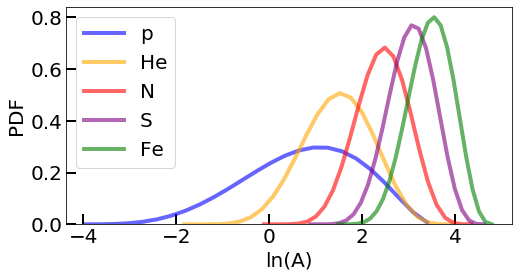

In [7]:
cl=find_A(r,add_name='_5_10-20_q1',manual=False)
add_name='_9_10-20_q1'
cl.plot(save=True,appro=True)
R_to_A=cl.from_R_to_A()
R_to_A['real_A']=0
for typ in range(N_samples):
    R_to_A['real_A'][R_to_A['type_part']==m_name[typ]]=m[typ]
print(round(fcn(R_to_A)))

## Гистограмма выхода нейронной сети на тестовой выборке

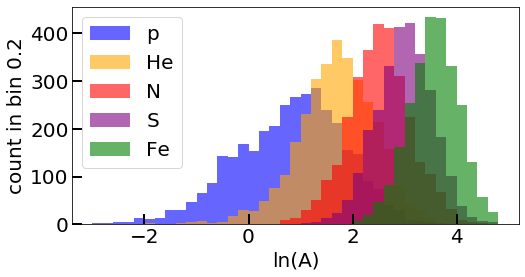

In [9]:
hist_3(r,norm=False,step_bins=0.2,save=True,add_name='1')

## Массовое распределение

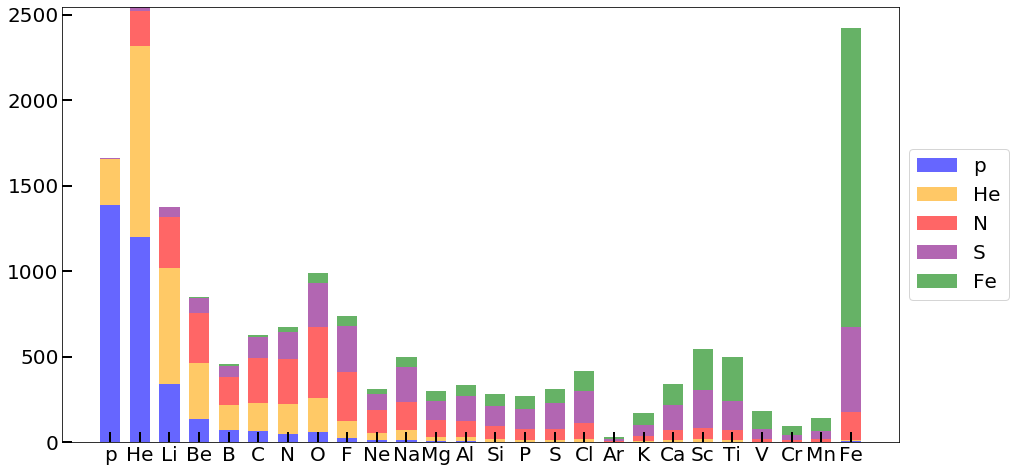

In [10]:
cl.mass_distribution()

## Параметризация распределений Бета-распределением

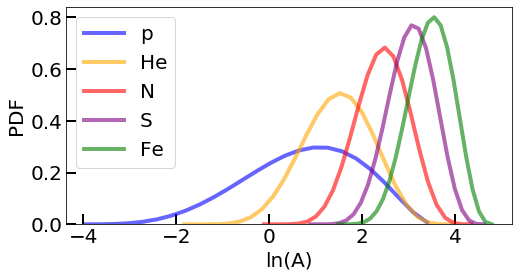

In [14]:
cl.plot(appro=True)

## Аппроксимация границ распределений

(-4.274656290466075,
 1.7743897879244477,
 -0.08923775834023136,
 3.5215148641644793,
 0.3768648602577114,
 -0.010424743519048476)

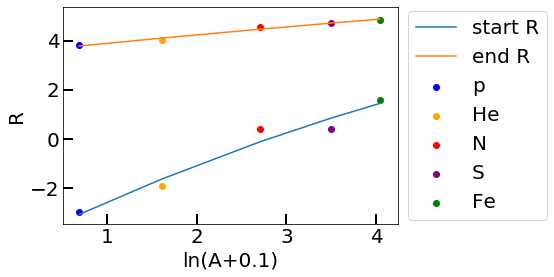

In [12]:
cl.fit_border(graph=True)

## Аппроксимация параметров Бета-распределения

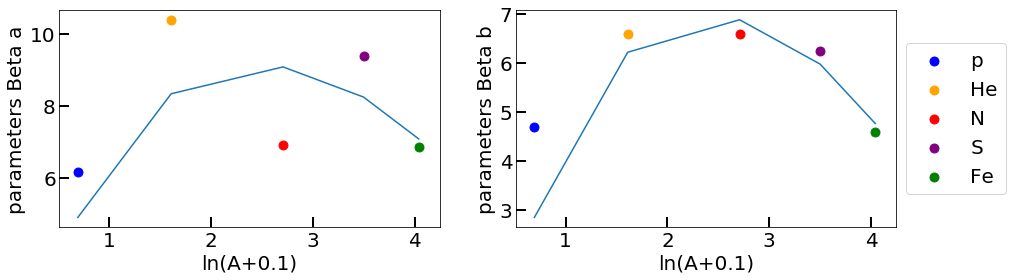

In [15]:
cl.plot_appro_Beta()

## Выборочные средние (точки) относительно истинных масс (линии)

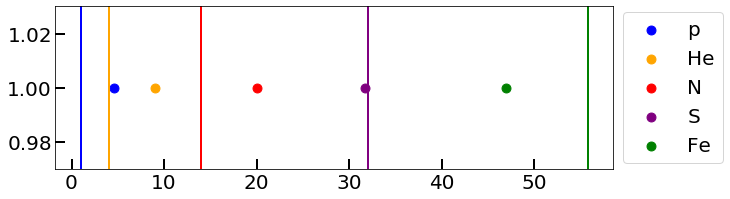

In [16]:
fig,ax=plt.subplots(figsize=(10,3))

mA=mean_A(R_to_A)
for i in range(N_samples):
    plt.scatter(np.array(mA)[i],[1],color=color7[i],s=80,label=m_name[i])
    plt.axvline(np.array(mA.index)[i],color=color7[i],linewidth=2)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=20)
plt.savefig('mean_A_9all_500_convert',bbox_inches='tight')

## Аппроксимация зависимости истинных масс от выборочных средних

error 3.9030960061908204
error general 0.7294789476597269


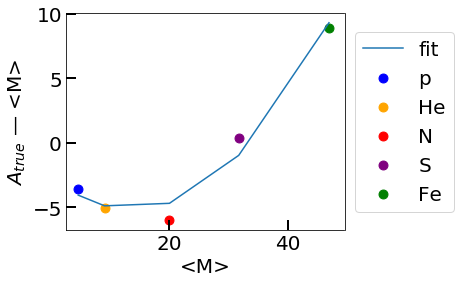

In [19]:
mA=mean_A(R_to_A)
p0,p1,p2=appro_c(np.array(mA),(np.array(mA.index)-np.array(mA)),print_error=True)
y=p0+p1*np.array(mA)+p2*(np.array(mA))**2
# print('error general', sum(abs(y+np.array(mA)-np.array(mA.index))/np.array(mA.index)))
print('error general', sum(abs(y+np.array(mA)-np.array(mA.index)))/5)

# plt.rcParams.update({'font.size':20})
# plt.rc('xtick', labelsize=20)
# plt.rc('ytick', labelsize=20)


fig=plt.figure(figsize=(5,4))
for i in range(N_samples):
    plt.scatter(np.array(mA)[i],np.array(mA.index)[i]-np.array(mA)[i],color=color7[i],s=80,label=m_name[i])
df_y=pd.DataFrame({'y_compute':np.array(mA),'y':y})
# print(df_y['y_compute'].to_numpy())
# df_y.sort_values(by=['y_compute'])
# plt.ylim(-22,12)
df_y=df_y.sort_values(by=['y_compute'])
plt.plot(df_y['y_compute'].to_numpy(),df_y['y'],label='fit')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=20)
plt.xlabel('<M>')
plt.ylabel(r'$A_{true}$ — <M>')

plt.savefig('mean_A_5_900',bbox_inches='tight')

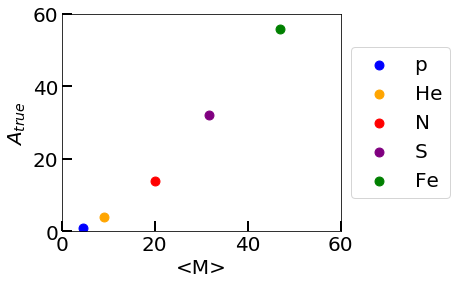

In [17]:
fig,ax=plt.subplots(figsize=(5,4))

mA=mean_A(R_to_A)
for i in range(N_samples):
    plt.scatter(np.array(mA)[i],np.array(mA.index)[i],color=color7[i],s=80,label=m_name[i])
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=20)
plt.xlim(0,60)
plt.ylim(0,60)
plt.ylabel(r'$A_{true}$')
plt.xlabel('<M>')
plt.savefig('mean_A_5_convert',bbox_inches='tight')

## Оцененные массы известных типов ядер

error 3.9030960061908204
error general 3.6473947382986345


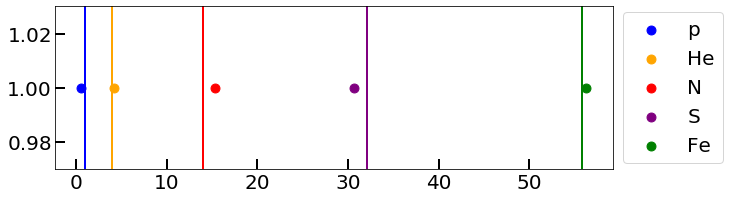

In [18]:
mA=mean_A(R_to_A)
p0,p1,p2=appro_c(np.array(mA),(np.array(mA.index)-np.array(mA)),print_error=True)
y=p0+p1*np.array(mA)+p2*(np.array(mA))**2
# print('error general', sum(abs(y+np.array(mA)-np.array(mA.index))/np.array(mA.index)))
print('error general', sum(abs(y+np.array(mA)-np.array(mA.index))))

fig,ax=plt.subplots(figsize=(10,3))

plt.rcParams.update({'font.size':20})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
mA=mean_A(R_to_A)
for i in range(N_samples):
    plt.scatter(np.array(mA)[i]+y[i],[1],color=color7[i],s=80,label=m_name[i])
    plt.axvline(np.array(mA.index)[i],color=color7[i],linewidth=2)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=20)
plt.savefig('mean_A_5_convert_',bbox_inches='tight')

## Оцененные массы относительно истинных масс для двух моделей ядерногоо взаимодействия

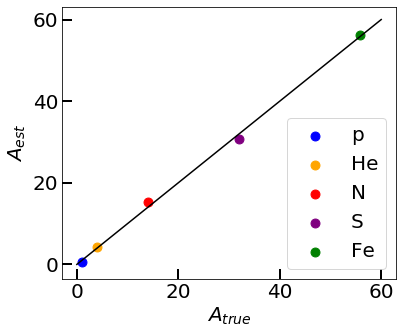

In [20]:
add_name='5'
fig,ax=plt.subplots(figsize=(6,5))
sum_err=0
xx=np.linspace(0,60,100)
yy=xx
plt.plot(xx,yy,color='black')
for i in range(N_samples):
    plt.scatter(m[i],np.array(mA)[i]+y[i],label=m_name[i],color=color7[i],s=80)
    sum_err+=np.array(mA)[i]+y[i]-m[i]
plt.legend(loc='lower right') #loc='center left', bbox_to_anchor=(1,0.5))
# plt.xlabel('Истинные массы')
# plt.ylabel('Оцененные массы')
plt.xlabel(r'$A_{true}$')
plt.ylabel(r'$A_{est}$')
plt.savefig('mean_A_real_1_'+add_name,bbox_inches='tight')

# Поиск средних масс по всей выборке

In [33]:
cl=find_A(r,add_name='_5_q1q2_10-20',manual=False)
f_arr,min_possible_r,max_possible_r =cl.interpolate_distr()

In [34]:
def extract_data(probab):
    p=df_pred['pred'][df_pred['m_name']==m_name[0]]
    mask=np.random.choice(a=[True, False], size=(len(p)), p=[probab[0], 1-probab[0]])
    p2n=p[mask]
    p2n.index=np.arange(len(p2n))
    
    He=df_pred['pred'][df_pred['m_name']==m_name[1]]
    mask=np.random.choice(a=[True, False], size=(len(He)), p=[probab[1], 1-probab[1]])
    He2n=He[mask]
    He2n.index=np.arange(len(He2n))
    
    N=df_pred['pred'][df_pred['m_name']==m_name[2]]
    mask=np.random.choice(a=[True, False], size=(len(N)), p=[probab[2], 1-probab[2]])
    N2n=N[mask]
    N2n.index=np.arange(len(N2n))
    
    S=df_pred['pred'][df_pred['m_name']==m_name[3]]
    mask=np.random.choice(a=[True, False], size=(len(S)), p=[probab[3], 1-probab[3]])
    S2n=S[mask]
    S2n.index=np.arange(len(S2n))
    
    Fe=df_pred['pred'][df_pred['m_name']==m_name[4]]
    mask=np.random.choice(a=[True, False], size=(len(Fe)), p=[probab[4], 1-probab[4]])
    Fe2n=Fe[mask]
    Fe2n.index=np.arange(len(Fe2n))
    
    df_together=pd.concat([p2n,He2n,N2n,S2n,Fe2n],keys=[0,1,2,3,4])
    return df_together

In [35]:
def from_R_to_A_mix(f_arr,min_possible_r,max_possible_r,r_mix):
    R_to_A_mix=pd.DataFrame(index=np.arange(len(df)),columns=['R','A','type_part'])
    add_toi=0
    for j in range(N_samples):
        print(j)
        for i in range(len(r_mix[j][:])):
            real_i=i+add_toi
            R_to_A_mix['R'].loc[real_i]=r_mix[j][i]
            R_to_A_mix['type_part'].loc[real_i]=m_name[j]
            #         print(R_toA(R_to_A['R'].loc[i]))
            if R_to_A_mix['R'].loc[real_i] >= max_possible_r:  #   error!!!!!!!!!!!!!!!!!!
                A_res=m[0]
            elif R_to_A_mix['R'].loc[real_i] <= min_possible_r :
                A_res=m[N_samples-1] 
            else:    
    #             y_interp_arr=[]
                y_df=pd.DataFrame(index=np.arange(len(mass_toFe)),columns=['A','y'])
                y_df['A']=mass_toFe
                summ=0
                for part in range(len(mass_toFe[:])):
                    try: 
                        summ+=1
                        y_interp=f_arr[part](R_to_A_mix['R'].loc[real_i])
    #                     print(y_interp)
    #                     y_interp_arr.append(y_interp)
                        y_df['y'].loc[part]=y_interp
                    except:
                        y_df['y'].loc[part]=0
                try:
                    y_max=max(y_df['y'])

                except:
                    y_max=max(y_df['y'])
    #             print('R', R_to_A['R'].loc[real_i], y_df['y'])    
    #                 print(y_max)
    #             print(y_df['A'][y_df['y']==y_max])
                A_res=float(y_df['A'][y_df['y']==y_max])
        #         print(summ)
        #         print(y_interp_arr)

    #         print(R_to_A['R'].loc[real_i], A_res)
            R_to_A_mix['A'].loc[real_i]=A_res
    #         if (real_i+1)%200==0: print(real_i)
        add_toi+=len(r_mix[j])   
    return R_to_A_mix # return R_to_A_mix

In [36]:
def find_aver_A(R_to_A_mix):
    Ni=np.zeros(26)
    for i in range(26):
        Ni[i]=np.count_nonzero(R_to_A_mix['A'][(R_to_A_mix['A']<(mass_toFe[i]+0.1))&(R_to_A_mix['A']>(mass_toFe[i]-0.1))])
    # Ni
    m_aver=sum(mass_toFe*Ni)/np.count_nonzero(R_to_A_mix['A'])
#     print(m_aver)

    Nri=np.zeros(N_samples)
    for i in range(N_samples):
        Nri[i]=np.count_nonzero(R_to_A_mix['type_part'][R_to_A_mix['type_part']==m_name[i]])
    # Nri
    A_aver_real=sum(m*Nri)/np.count_nonzero(R_to_A_mix['A'])
#     print(A_aver_real)
    return m_aver,A_aver_real,Ni,Nri    #return m_aver, A_aver_real

In [39]:
probab_c=[ [1,0.8, 0.1, 0.02,0.01 ],
          [1,0.1, 0.1, 0.02,0.01  ],
          [0.9,1, 0.2, 0.1,0.01 ],
          [0.6,1, 0.3, 0.2,0.1],
          [0.6,0.8, 1, 0.3,0.4],
          [0.6,0.5, 1, 0.8,0.6],
         [1,0.03, 0.03, 0.003,0.003],
         [0.6,1, 0.1, 0.1,0.1],
         [0.6,0.6, 1, 0.03,0.03],
         [0.3,0.4, 0.5, 1,0.1],
         [0.9,0.5, 0.01, 0.02,0.01],
         [0.9,0.2, 0.01, 0.02,0.01],
         [0.9,0.2, 0.1, 0.2,0.1],
         [0.2,0.2, 0.2, 0.2,0.6]]

## Составление выборок с разными итоговыми средними массами из данных о двух моделях взаимодействия

In [40]:
df_mass_result=pd.DataFrame(index=np.arange(len(probab_c)),columns=['mass_mean','A_mean_true','Ni','Nri'])
probab_min=0.3
probab=np.array([probab_min]*N_samples)
j=0

for i in range(len(probab_c)):
    print('# = ', i)
    df=extract_data(probab_c[i])
    r_mix=df
    R_to_A_mix=from_R_to_A_mix(f_arr,min_possible_r,max_possible_r,r_mix)
    mass_mean,A_mean_true,Ni,Nri=find_aver_A(R_to_A_mix)
    print(mass_mean,A_mean_true,Ni,Nri)
    df_mass_result.loc[i]=mass_mean,A_mean_true,Ni,Nri

# =  0
0
1
2
3
4
8.155871946392788 3.36052875751503 [2179. 2149. 1094.  544.  363.  279.  273.  236.  179.   97.   84.   59.
   49.   35.   60.   37.   38.    4.   26.   21.   18.   17.   12.    7.
   11.  113.] [4266. 3246.  357.   78.   37.]
# =  1
0
1
2
3
4
7.222672686884297 2.9758292833687467 [1855. 1375.  609.  302.  181.  124.  123.  121.   97.   48.   38.   30.
   25.   22.   24.   28.   18.    2.   20.    8.   14.   10.    8.    5.
    3.   87.] [4266.  422.  386.   72.   31.]
# =  2
0
1
2
3
4
9.797029736695922 4.880672436395956 [2085. 2282. 1254.  630.  416.  336.  363.  294.  220.  141.  126.   85.
   85.   56.   71.   52.   66.    5.   40.   34.   56.   32.   20.   17.
   13.  222.] [3852. 4011.  730.  378.   30.]
# =  3
0
1
2
3
4
13.036484108589026 8.627189757043459 [1577. 1948. 1150.  625.  410.  344.  379.  335.  265.  179.  159.  114.
   98.   82.  103.   60.   91.    8.   69.   56.   66.   52.   40.   35.
   25.  497.] [2604. 4011. 1106.  712.  334.]
# =  4
0
1
2
3
4
18

## Аппроксимация сдвига истинной массы от выборочного среднего 

[ 5.68368059 11.27640474 16.86912889 22.46185303 28.05457718] 5.683680589669698 28.054577181421198
10.4360773452327


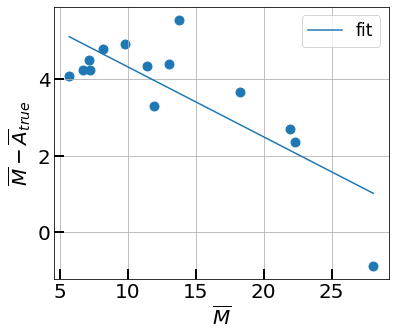

In [41]:
p0_est,p1_est=appro_ab(np.array(df_mass_result['mass_mean']),np.array(df_mass_result['mass_mean']-
                                                                     df_mass_result['A_mean_true']))
A_est=df_mass_result['mass_mean']-p0_est-p1_est*df_mass_result['mass_mean']
def f_line(p0,p1,x):
    return p0+p1*x
x_many=np.linspace(df_mass_result['mass_mean'].min(),df_mass_result['mass_mean'].max(),5)
print(x_many,df_mass_result['mass_mean'].min(),df_mass_result['mass_mean'].max())
err_A=sum(abs(A_est-df_mass_result['A_mean_true']))
print(err_A)
fig=plt.figure(figsize=(6,5))
plt.scatter(df_mass_result['mass_mean'],df_mass_result['mass_mean']-df_mass_result['A_mean_true'],s=80)
plt.plot(x_many,f_line(p0_est,p1_est,x_many),label='fit')
plt.xlabel(r'$\overline{M}$')
plt.ylabel(r'$\overline{M}-\overline{A}_{true}$')
plt.legend(fontsize=17)
plt.grid()
# plt.text(14.5,27,'$MAE = 4.7$')
plt.savefig('A_aver_true_.png',bbox_inches='tight')

In [42]:
df_A_out=pd.DataFrame({'A_est':A_est,'A_true':df_mass_result['A_mean_true']})
df_A_out

,A_est,A_true
0,3.49512,3.36053
1,2.3913,2.97583
2,5.43634,4.88067
3,9.26809,8.62719
4,15.413,14.5713
5,20.2418,19.9615
6,0.570924,1.59752
7,7.37006,7.07359
8,10.0953,8.18578
9,19.7811,19.2222


In [49]:
df_A_out1=df_A_out.drop(8)
df_A_out1

,A_est,A_true
0,3.49512,3.36053
1,2.3913,2.97583
2,5.43634,4.88067
3,9.26809,8.62719
4,15.413,14.5713
5,20.2418,19.9615
6,0.570924,1.59752
7,7.37006,7.07359
9,19.7811,19.2222
10,2.3337,2.68297


In [50]:
sum(abs(df_A_out1['A_est']-df_A_out1['A_true']))/len(df_A_out1['A_est'])

0.6558862621742699

## Оценка восстановления средней массы по всей выборке 

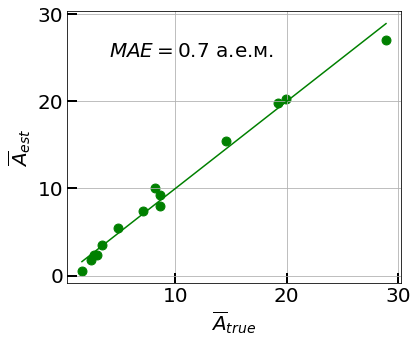

In [53]:
fig,ax=plt.subplots(figsize=(6,5))
    
plt.scatter(df_mass_result['A_mean_true'],A_est,s=80,color='green')  
# plt.axhline(15,color='gray',linewidth=2,linestyle='--',label='истинные массы')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=20)
x=np.linspace(min(df_A_out['A_true']),max(df_A_out['A_true']),100)
y=x
plt.plot(x,y,color='green')
plt.xlabel('Истинные средние массы')
plt.ylabel('Оцененные средние массы')
plt.xlabel(r'$\overline{A}_{true}$')
plt.ylabel(r'$\overline{A}_{est}$')
plt.text(4,25.2,'$MAE = 0.7~$а.е.м.')
plt.grid()
plt.savefig('A_est_true_2_'+add_name,bbox_inches='tight')